# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [28]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import svm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV

from tqdm.notebook import trange, tqdm
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.001, 0.01, 0.1, 1, 10, 100],\
              'decision_function_shape' : ['ovo', 'ovr']}
svr = SVC(verbose = False, probability=True)
clf = GridSearchCV(svr, parameters, scoring=my_scorer, cv=2, verbose=2)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)
print('Best parameters: ', clf.best_params_)
print("F1 score  = {0:6.2f}".format(f1_score(y_test, np.argmax(pred, axis=1), average='micro')))We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2]$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 


$$L^{'}_{w}(w, w_0) = \frac{1}{N} \sum_{i=1}^N \frac{-y_i x_i}{1 + \exp(y_i(w^\top x_i + w_0)))} + \gamma \cdot sign(w) + 2\beta w$$.

$$L^{'}_{w_0}(w, w_0) = \frac{1}{N} \sum_{i=1}^N \frac{-y_i}{1 + \exp(y_i(w^\top x_i + w_0)))}$$.

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [3]:
def m_1(x: List[float]) -> float:
    return np.linalg.norm(x, 1)

def m_2(x: List[float]) -> float:
    return np.linalg.norm(x, 2)

In [4]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return np.log(1 + np.exp(np.multiply(-y, (w@X.T + w0)))).mean() + gamma * m_1(w) + beta * (m_2(w) ** 2)

#### 3. [0.5 points] Implement the gradient (as a function)

In [5]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    sig = (-y) / (1 + np.exp(np.multiply(y, (w@X.T + w0))))
    grad_w0 = sig.mean()
    grad_w = ((sig@X) / len(y)) + gamma * np.sign(w) + 2 * beta * w    
    return grad_w, grad_w0

#### Check yourself

In [6]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
print(grad_w)
print(grad_w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
-0.20782319347690742


####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [8]:
class Logit(BaseEstimator, ClassifierMixin):
    
    negative_class = -1
    positive_class = 1
    
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = None

    def fit(self, X, y):
        self.loss_history = []
        
        np.random.seed(self.random_state)
        
        self.w = np.random.sample(X.shape[1])
        self.w0 = np.random.sample(1)
        
        self.loss_history.append(self.calc_loss(X, y))
        
        for iter_num in trange(2, self.max_iter + 1):
            self.iter = iter_num
            
            if self.loss_history[-1] <= self.tolerance:
                print("Reached tolerance")
                return self
                
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w = self.w - self.learning_rate * grad_w
            self.w0 = self.w0 - self.learning_rate * grad_w0
            
            self.loss_history.append(self.calc_loss(X, y))

        return self

    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
            
        self_pred, _ = self.predict_proba(X)
        
        bin_classes = np.zeros_like(self_pred)
        
        bin_classes[self_pred < 0.5] = self.positive_class
        bin_classes[self_pred >= 0.5] = self.negative_class
        
        return bin_classes

        
    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)),\
                         1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])
    
    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """
        
        return loss(X, y, self.w, self.w0, self.gamma, self.beta)

In [9]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [10]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

  0%|          | 0/999 [00:00<?, ?it/s]

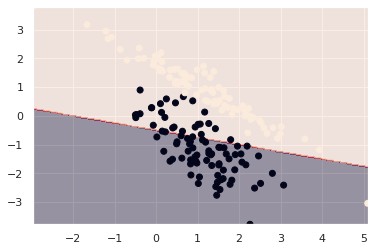

In [11]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

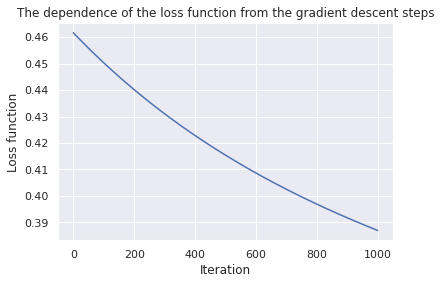

In [12]:
plt.plot([x for x in range(0, len(model.loss_history))], model.loss_history, label='The dependence of the loss function from the gradient descent steps')
plt.xlabel("Iteration")
plt.ylabel("Loss function")
plt.title('The dependence of the loss function from the gradient descent steps')
plt.show()

It can be seen that loss gets smaller over iteration, but change is not peaky.

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

In [14]:
def _precision(_y, _pred_y, _proba):
    return precision_score(_y, _pred_y, average='macro')

def _recall(_y, _pred_y, _proba):
    return recall_score(_y, _pred_y, average='macro')

def _f1(_y, _pred_y, _proba):
    return f1_score(_y, _pred_y, average='macro')

def _accuracy(_y, _pred_y, _proba):
    return accuracy_score(_y, _pred_y)

def _roc_auc(_y, _pred_y, _proba):
    return roc_auc_score(_y, _proba[:,1])

In [26]:
_metrics = {
    'Precision': _precision,
    'Recall': _recall,
    'F1-score': _f1,
    'Accuracy': _accuracy,
    'ROC-AUC': _roc_auc,
}

_labels = ['Negative', 'Positive']

def show_results(_y, _pred_y, _proba):
    for metric_label in _metrics:
        print(f"{metric_label}: {_metrics[metric_label](_y, _pred_y, _proba):6.2f}")
    print("\n")

def show_confusion_matrix(_y, _pred_y, ax):
    
    _confusion_matrix = confusion_matrix(_y, _pred_y)
    sns.heatmap(ax=ax, data=_confusion_matrix, annot=True, fmt="d", cbar=False, xticklabels=_labels, yticklabels=_labels)

Linear

Precision:   0.98
Recall:   0.98
F1-score:   0.98
Accuracy:   0.98
ROC-AUC:   1.00


RBF

Precision:   0.98
Recall:   0.98
F1-score:   0.98
Accuracy:   0.98
ROC-AUC:   1.00


Poly

Precision:   0.98
Recall:   0.98
F1-score:   0.98
Accuracy:   0.98
ROC-AUC:   1.00


Poly, With Custom Degree

Precision:   0.82
Recall:   0.75
F1-score:   0.73
Accuracy:   0.74
ROC-AUC:   0.01




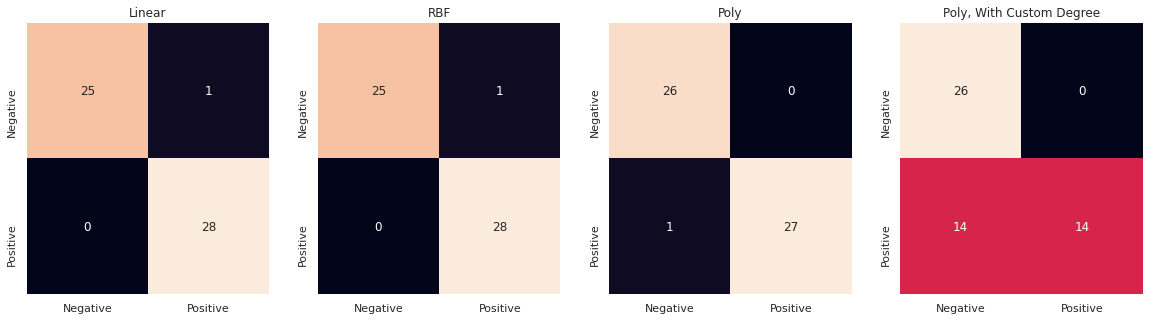

In [27]:
_models = {
    'Linear': svm.SVC(kernel='linear',probability=True),
    'RBF': svm.SVC(kernel='rbf',probability=True),
    'Poly': svm.SVC(kernel='poly',probability=True),
    'Poly, With Custom Degree': svm.SVC(kernel='poly', degree=8, probability=True),
}

_model_labels = [
    'Linear',
    'RBF',
    'Poly',
    'Poly, With Custom Degree',
]

np.random.seed(60)
fig, axs = plt.subplots(1, len(_model_labels), figsize=(20, 5))

for i in range(len(_model_labels)):
    _model_label = _model_labels[i]
    
    _model = _models[_model_label]
    _model.fit(X_train, y_train)
    
    ax = axs[i]
    ax.set_title(f"{_model_label}")
    
    y_pred = _model.predict(X_test)
    proba  = _model.predict_proba(X_test)
    
    print(f"{_model_label}\n")
    show_results(y_test, y_pred, proba)
    show_confusion_matrix(y_test, y_pred, ax)

It can be seen that among models, the best one were linear and rbf, as for poly it show better result using default degree=3, than with custom(degree=8).

In [ ]:
my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.001, 0.01, 0.1, 1, 10, 100],\
              'decision_function_shape' : ['ovo', 'ovr']}
svr = SVC(verbose = False, probability=True)
clf = GridSearchCV(svr, parameters, scoring=my_scorer, cv=2, verbose=2)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)
print('Best parameters: ', clf.best_params_)
print("F1 score  = {0:6.2f}".format(f1_score(y_test, np.argmax(pred, axis=1), average='micro')))

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 100
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [17]:
# your code here

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. 
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. 
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

In [18]:
# your code here

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

In [19]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score)
* make conclusions about the model

In [20]:
# your code here